# Experimental Configuration

## Confocal Controls 

Time Estimate (min): 0.4166666666666667, Started at: 2025-04-04 14:12:16.417926
    This took: 0.4381366809209188


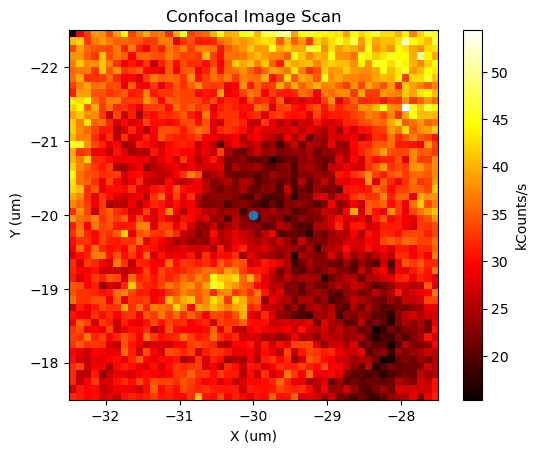

In [155]:
__all__ = ["ConfocalControls"]

import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

# basic Imports
import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from NV_ABJ import ScannerSingleAxis, PhotonCounter

class ConfocalControls:
    def __init__(self,scanner_x:ScannerSingleAxis,scanner_y:ScannerSingleAxis,scanner_z:ScannerSingleAxis,photon_counter:PhotonCounter,
                 tracking_xy_span:float = 3e-6,tracking_z_span:float = 3e-6,tracking_dwell_time_s:float = 5e-3,tracking_xy_number_of_points:int = 10,tracking_z_number_of_points:int = 20):
        self.scanner_x = scanner_x
        self.scanner_y = scanner_y
        self.scanner_z = scanner_z
        self.photon_counter = photon_counter
        
        # Tracking parameters
        self.tracking_xy_span = tracking_xy_span
        self.tracking_z_span = tracking_z_span
        self.tracking_dwell_time_s = tracking_dwell_time_s
        self.tracking_xy_number_of_points = tracking_xy_number_of_points
        self.tracking_z_number_of_points = tracking_z_number_of_points





    def xy_scan(self,dwell_time_s:float,x_positions:NDArray,y_positions:NDArray,z_position:float)-> tuple[NDArray,NDArray,NDArray]:
        """An xy scan has the same z height for all points and translates to the x and y positions. This instance of the xy 
        scan iterates between scanning forward and backward so there is no sudden movement to the confocal. The arrays from 
        x and y when added will be sorted to ensure the locations are sequential. 

        Args:
            dwell_time_s (float): How long we dwell at each point before moving to the next point
            x_positions (NDArray): An array of the x_positions you want to scan over 
            y_positions (NDArray): An array of the y_positions you want to scan over 
            z_position (float): The z position we want to scan at

        Returns:
            NDArray: Photon counts. A 2D array of the photons per second at each point in the x y positions 
            NDArray: X positions. A sorted x array of the positions passed originally to the function 
            NDArray: Y positions. A sorted y array of the positions passed originally to the function
        """

        # Making sure the lists are ordered correctly 
        x_positions = sorted(x_positions)
        y_positions =  sorted(y_positions)

        # Getting the basic length which is repeatedly used
        x_length = len(x_positions)

        # Pre allocating matrices
        xy_counts = np.zeros((x_length,len(y_positions)))
        line_counts = np.zeros(x_length)

        # Reversed list to go backward with every other iteration
        reversed_x = x_positions[::-1]
    
        # Getting original z to return to 
        z_original = self.scanner_z._position_m
        
        # Opening all scanners and photon counters
        with self.scanner_x as x_con, self.scanner_y as y_con, self.scanner_z as z_con, self.photon_counter as pc:
            # Sets the initial position to be location at the place that the user requested
            z_con.set_position_m(z_position)

            # Iterates through y setting the position once per line 
            for ind_y,y_loc in enumerate(y_positions):
                y_con.set_position_m(y_loc)

                # Flips the even and odd rows so we don't have jumps going back and forth on the x axis 
                if ind_y%2 == 0:
                    for ind_x,x_loc in enumerate(x_positions):
                        x_con.set_position_m(x_loc)
                        counts = pc.get_counts_per_second(dwell_time_s=dwell_time_s)
                        line_counts[ind_x] = counts

                else:
                    for ind_x,x_loc in enumerate(reversed_x):
                        x_con.set_position_m(x_loc)
                        counts = pc.get_counts_per_second(dwell_time_s=dwell_time_s)
                        line_counts[(x_length-1)-ind_x] = counts

                # Adds a full line at a time 
                xy_counts[ind_y,:] = line_counts

            
            # Resetting back to original z position
            z_con.set_position_m(z_original)

        return xy_counts,np.array(x_positions),np.array(y_positions)
    
    def z_scan(self,dwell_time_s:float,x_position:float,y_position:float, z_positions:NDArray)->tuple[NDArray,NDArray]:
        """This is a z scan over a stationary xy position. It then goes through the z positions sequential
         after ordering the lists to be in the correct orientation

        Args:
            dwell_time_s (float): How long we dwell at each point before moving to the next point
            x_position (float): An array of the x position you want to scan at 
            y_position (float): An array of the y position you want to scan at 
            z_positions (NDArray): An array of the z positions you want to scan over 

        Returns:
            NDArray: Photon counts. An array of the photons per second at each point in the z positions
            NDArray: Z positions. A sorted array for the z positions 
        """
        # Sorting z list
        z_positions = sorted(z_positions)

        # Preallocating z counts
        photon_counts = np.zeros(len(z_positions))

        # Getting original z to return to 
        z_original = self.scanner_z._position_m
        
        # Opening all scanners and photon counters
        with self.scanner_x as x_con, self.scanner_y as y_con, self.scanner_z as z_con, self.photon_counter as pc:
            
            # Setting the xy position of interest 
            x_con.set_position_m(x_position)
            y_con.set_position_m(y_position)

            # Iterating over all desired z positions 
            for ind_z,z_loc in enumerate(z_positions):
                z_con.set_position_m(z_loc)
                photon_counts[ind_z] = pc.get_counts_raw(dwell_time_s)

            # Resetting back to original z position
            z_con.set_position_m(z_original)
        
        return photon_counts,np.array(z_positions)
    
    def tracking(self,x_position:float,y_position:float,z_position:float)->tuple[float,float,float]:
        xy_span = self.tracking_xy_span
        z_span = self.tracking_z_span
        dwell_time_s = self.tracking_dwell_time_s
        xy_number_of_points = self.tracking_xy_number_of_points
        z_number_of_points = self.tracking_z_number_of_points

        x_positions = np.linspace(x_position-xy_span/2,x_position+xy_span/2,xy_number_of_points)
        y_positions = np.linspace(y_position-xy_span/2,y_position+xy_span/2,xy_number_of_points)
        z_positions = np.linspace(z_position-z_span/2,z_position+z_span/2,z_number_of_points)


        xy_2d_scan, _ , _ = self.xy_scan(dwell_time_s,x_positions,y_positions,z_position)

        flat_index = np.argmax(xy_2d_scan)

        row_index, col_index = np.unravel_index(flat_index, xy_2d_scan.shape)

        x_pos = x_positions[row_index]
        y_pos = y_positions[col_index]

        z_1d_scan, _ = self.z_scan(dwell_time_s,x_pos,y_pos,z_positions)

        z_pos = z_positions[np.argmax(z_1d_scan)]

        return x_pos,y_pos,z_pos
    



from NV_ABJ.hardware_interfaces.scanner.ni_daq_scanner.ni_daq_scanner import NiDaqSingleAxisScanner
from NV_ABJ.hardware_interfaces.photon_counter.ni_daq_counters.ni_photon_counter_daq_controlled import NiPhotonCounterDaqControlled
# from NV_ABJ.experimental_logic.confocal_scanning import ConfocalControls 

confocal_x = NiDaqSingleAxisScanner(conversion_volts_per_meter_setting=10/(50e-6),
                                              device_name_output="PXI1Slot5",
                                              channel_name_output="ao0",
                                              position_limits_m=(-50e-6,50e-6))

confocal_y = NiDaqSingleAxisScanner(conversion_volts_per_meter_setting=10/(50e-6),
                                              device_name_output="PXI1Slot5",
                                              channel_name_output="ao1",
                                              position_limits_m=(-50e-6,50e-6))


confocal_z = NiDaqSingleAxisScanner(conversion_volts_per_meter_setting=10/(50e-6),
                                              device_name_output="PXI1Slot4",
                                              channel_name_output="ao3",
                                              position_limits_m=(-50e-6,50e-6))

photon_counter = NiPhotonCounterDaqControlled(device_name="PXI1Slot3",
                                                counter_pfi="pfi0",
                                                trigger_pfi="pfi2")

confocal = ConfocalControls(confocal_x,confocal_y,confocal_z,photon_counter)


# Setting the default locations to 0
with confocal_x, confocal_y, confocal_z:
    confocal_x.set_position_m(0)
    confocal_y.set_position_m(0)
    confocal_z.set_position_m(0)

dwell_time_s = 5e-3

z_position = -8.5e-6
x_position = -30e-6
y_position = -20e-6
num_points = 50
span = 5e-6

if False:
    x_positions = np.linspace(-50e-6,50e-6,num_points)
    y_positions = np.linspace(-50e-6,50e-6,num_points)
else:
    x_positions = np.linspace(x_position - span/2,x_position+ span/2,num_points)
    y_positions = np.linspace(y_position - span/2,y_position+ span/2,num_points)

print(f"Time Estimate (min): {2*dwell_time_s*len(x_positions)*len(y_positions)/60}, Started at: {datetime.datetime.fromtimestamp(start_time:=time.time())}")
xy_counts,x_positions,y_positions = confocal.xy_scan(dwell_time_s,x_positions,y_positions,z_position)
print(f"    This took: {(time.time()-start_time)/60}")


img = plt.imshow(xy_counts/1000, cmap='hot', extent=(min(x_positions)*1e6,max(x_positions)*1e6,max(y_positions)*1e6,min(y_positions)*1e6))  # Use a colormap for visualization
cbar = plt.colorbar(img)
#plt.clim(2.25,13.25)
cbar.set_label("kCounts/s")

plt.scatter(-30,-20)

plt.title("Confocal Image Scan")
plt.xlabel("X (um)")
plt.ylabel("Y (um)")
plt.show()



## Sequence Generation Controls 

In [18]:
from NV_ABJ.hardware_interfaces.sequence_generation.spbicl_pulse_blaster.SpbiclPulseBlaster import SpbiclPulseBlaster
from NV_ABJ import SequenceDevice

sequence_generator = SpbiclPulseBlaster()

microwave_switch = SequenceDevice(address=0,
                                  device_label="Microwaves")

apd_trigger = SequenceDevice(address=1,
                             device_label="APD")

aom_trigger = SequenceDevice(address=2,
                             device_label="AOM")

## Signal Generation

In [19]:
from NV_ABJ.hardware_interfaces.microwave_source.sg380.sg380 import SG380

srs_address = 'GPIB0::27::INSTR'
signal_generator_1 = SG380(gpib_address=srs_address)

# Turning On Pulse Blaster Bits 

In [20]:
# Just turning on these devices 
sequence_generator.stop()

microwave_switch.device_status = False
apd_trigger.device_status = False
aom_trigger.device_status = True

sequence_generator.update_devices([microwave_switch,apd_trigger,aom_trigger])


0

In [21]:
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

# Making a 2D scan

## Getting the Image Data 

In [165]:
dwell_time_s = 10e-3

z_position = -1.318421052631579e-05
x_position = -3.7500000000000003e-05
y_position = -2.5166666666666667e-05
num_points = 50

if False:
    x_positions = np.linspace(-50e-6,50e-6,num_points)
    y_positions = np.linspace(-50e-6,50e-6,num_points)
else:
    span = 5e-6
    x_positions = np.linspace(x_position - span/2,x_position+ span/2,num_points)
    y_positions = np.linspace(y_position - span/2,y_position+ span/2,num_points)

print(f"Time Estimate (min): {2*dwell_time_s*len(x_positions)*len(y_positions)/60}, Started at: {datetime.datetime.fromtimestamp(start_time:=time.time())}")
xy_counts,x_positions,y_positions = confocal.xy_scan(dwell_time_s,x_positions,y_positions,z_position)
print(f"    This took: {(time.time()-start_time)/60}")

Time Estimate (min): 0.8333333333333334, Started at: 2025-04-04 14:22:37.793976
    This took: 0.7524210651715596


## Graphing Image Scan

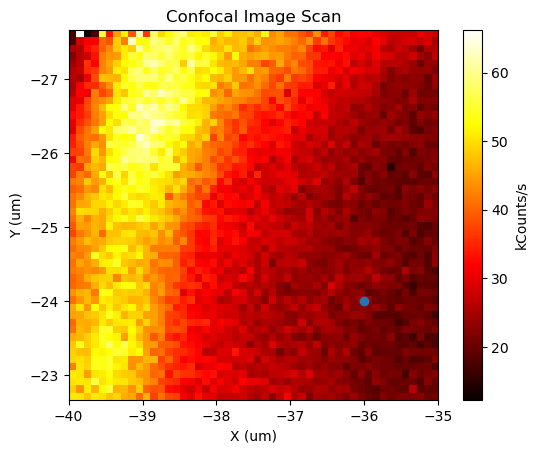

In [166]:
img = plt.imshow(xy_counts/1000, cmap='hot', extent=(min(x_positions)*1e6,max(x_positions)*1e6,max(y_positions)*1e6,min(y_positions)*1e6))  # Use a colormap for visualization
cbar = plt.colorbar(img)
#plt.clim(2.25,13.25)
cbar.set_label("kCounts/s")

plt.scatter(-36,-24)

plt.title("Confocal Image Scan")
plt.xlabel("X (um)")
plt.ylabel("Y (um)")
plt.show()


# Making a Z Scan

## Getting the Z Scan Data

In [161]:
dwell_time_s = 50e-3

number_of_positions = 200
z_positions = np.linspace(-50e-6,50e-6,number_of_positions)

print(f"Estimated Time (min){2*dwell_time_s*len(z_positions)/60}, Started at: {datetime.datetime.fromtimestamp(start_time:=time.time())}")
photon_counts, z_positions = confocal.z_scan(dwell_time_s,x_position,y_position,z_positions)
print(f"    This took: {(time.time()-start_time)/60}")

Estimated Time (min)0.3333333333333333, Started at: 2025-04-04 14:20:16.344855
    This took: 0.26282236178716023


## Graphing the Z Scan Data 

200 200


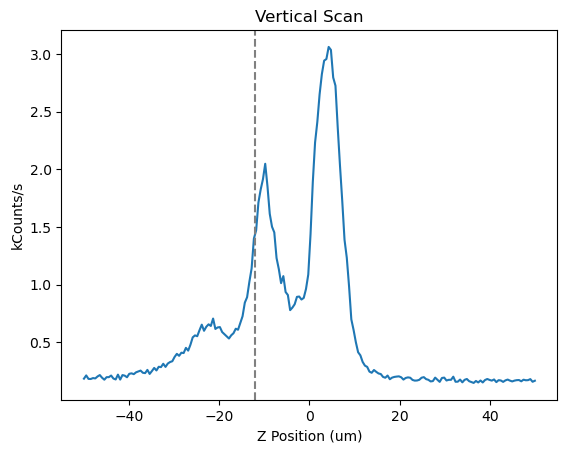

In [162]:
print(len(z_positions),len(photon_counts))

plt.plot(z_positions*1e6,photon_counts/1000)
plt.axvline(x=-12, linestyle = "--", color='grey', label='axvline - full height')
plt.title("Vertical Scan")
plt.xlabel("Z Position (um)")
plt.ylabel("kCounts/s")
plt.show()

In [164]:
print(f"Estimated Time (min){2*dwell_time_s*len(z_positions)/60}, Started at: {datetime.datetime.fromtimestamp(start_time:=time.time())}")
data = confocal.tracking(x_position,y_position,z_position)
print(f"    This took: {(time.time()-start_time)/60}")
print(data)

Estimated Time (min)0.3333333333333333, Started at: 2025-04-04 14:21:48.407051
    This took: 0.021851519743601482
(-3.7500000000000003e-05, -2.5166666666666667e-05, -1.318421052631579e-05)


In [ ]:
x_position = -31.5e-6
y_position = -33.5e-6
z_position = -3.5e-6

center = 2870 
span = 100
num = 100
frequencies = np.linspace(center-span/2,center+span/2,num)

with signal_generator_1 as srs, photon_counter as pc, confocal_x,confocal_y,confocal_z:
    ...
